In [ ]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from google.colab import drive

# Step 1: Load dataset from Excel

In [ ]:
# Mount Google Drive
drive.mount('/content/gdrive')

# Define file path (Update the filename to match your uploaded Excel file)
file_path = "/content/gdrive/My Drive/Colab Notebooks/topic.csv"


# Load dataset
df = pd.read_csv(file_path, encoding='latin-1') # Or try 'iso-8859-1' if 'latin-1' doesn't work

Mounted at /content/gdrive


# Ensure necessary columns exist

In [ ]:
assert {'Dholuo Phrase', 'Swahili Phrase', 'Thematic Area'}.issubset(df.columns), "Missing required columns!"

Step 2: Data Preprocessing
# Combine Dholuo and Swahili phrases into a single text input

In [ ]:
# Restructure dataset: Separate Dholuo and Swahili into individual rows
df_dholuo = df[['Dholuo Phrase', 'Thematic Area']].rename(columns={'Dholuo Phrase': 'Phrase'})
df_swahili = df[['Swahili Phrase', 'Thematic Area']].rename(columns={'Swahili Phrase': 'Phrase'})
df_final = pd.concat([df_dholuo, df_swahili], ignore_index=True)
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

# Encode labels
thematic_labels = {label: i for i, label in enumerate(df["Thematic Area"].unique())}
df["Thematic Area"] = df["Thematic Area"].map(thematic_labels)

In [ ]:
# Extract features and labels
swahili_texts = df["Swahili Phrase"]
dholuo_texts = df["Dholuo Phrase"]
labels = df["Thematic Area"]

In [ ]:
# Data Augmentation for underrepresented classes
from collections import Counter
import random

swahili_synonyms = {
    "elimu": ["masomo", "mafunzo"],
    "chakula": ["mlo", "lishe"],
    "magari": ["gari", "mashine"]
}

def replace_with_synonym(text):
    # Convert the input to string if it's not already
    text = str(text)
    words = text.split()
    new_words = []
    for word in words:
        if word in swahili_synonyms:
            new_words.append(random.choice(swahili_synonyms[word]))
        else:
            new_words.append(word)
    return ' '.join(new_words)

class_counts = Counter(labels)
max_count = max(class_counts.values())

aug_swahili = []
aug_dholuo = []
aug_labels = []

for cls in class_counts:
    count_diff = max_count - class_counts[cls]
    if count_diff > 0:
        class_df = df[df['Thematic Area'] == cls]
        for _ in range(count_diff):
            row = class_df.sample(1).iloc[0]
            aug_swahili.append(replace_with_synonym(row['Swahili Phrase']))
            aug_dholuo.append(row['Dholuo Phrase'])
            aug_labels.append(cls)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import XLMRobertaTokenizer
import torch
from torch.utils.data import Dataset

# Assuming your original dataframe 'df' has these columns:
# 'Swahili Phrase', 'Dholuo Phrase', 'Thematic Area'

# Example: load your data
# df = pd.read_csv('/path/to/your/file.csv', encoding='latin-1')

# 1. Split the dataframe into train, val, test with stratification on 'Thematic Area'
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df['Thematic Area'], random_state=42
)

val_df, test_df = train_test_split(
    temp_df, test_size=2/3, stratify=temp_df['Thematic Area'], random_state=42
)

# 2. Extract Swahili and Dholuo texts from each split as lists of strings
train_swahili = train_df['Swahili Phrase'].astype(str).tolist()
train_dholuo = train_df['Dholuo Phrase'].astype(str).tolist()
train_labels = train_df['Thematic Area']

val_swahili = val_df['Swahili Phrase'].astype(str).tolist()
val_dholuo = val_df['Dholuo Phrase'].astype(str).tolist()
val_labels = val_df['Thematic Area']

test_swahili = test_df['Swahili Phrase'].astype(str).tolist()
test_dholuo = test_df['Dholuo Phrase'].astype(str).tolist()
test_labels = test_df['Thematic Area']

# 3. Initialize the tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

# 4. Tokenization function combining Swahili and Dholuo phrases with [SEP]
def tokenize_texts(swahili_texts, dholuo_texts):
    combined_texts = [s + " [SEP] " + d for s, d in zip(swahili_texts, dholuo_texts)]
    return tokenizer(
        combined_texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

# 5. Tokenize all splits
train_encodings = tokenize_texts(train_swahili, train_dholuo)
val_encodings = tokenize_texts(val_swahili, val_dholuo)
test_encodings = tokenize_texts(test_swahili, test_dholuo)

# 6. Create Dataset class
class ThematicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels.values, dtype=torch.long)  # convert pandas Series to tensor

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# 7. Instantiate datasets
train_dataset = ThematicDataset(train_encodings, train_labels)
val_dataset = ThematicDataset(val_encodings, val_labels)
test_dataset = ThematicDataset(test_encodings, test_labels)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [ ]:
# Model
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=len(thematic_labels))
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [ ]:
# Training arguments
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=8,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    # Replace 'evaluation_strategy' with 'eval_strategy'
    eval_strategy="epoch", # Renamed in newer versions
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type="linear",
    gradient_accumulation_steps=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2
)

In [ ]:
from transformers import DataCollatorWithPadding # Import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

<ipython-input-12-137c5bfe5e33>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: edwinonkoba2016 (edwinonkoba2016-maseno-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.440800,1.389899,0.564010,0.532728,0.564010,0.519852
2,1.326700,1.220611,0.599282,0.592980,0.599282,0.580551
3,1.171000,1.139685,0.625408,0.615216,0.625408,0.612650
4,0.954200,1.138173,0.618877,0.609915,0.618877,0.610923
5,0.942100,1.139174,0.613978,0.604131,0.613978,0.600682
6,0.895500,1.151566,0.625082,0.619288,0.625082,0.616551
7,0.778200,1.178969,0.622796,0.615784,0.622796,0.616108
8,0.668400,1.206010,0.619530,0.615161,0.619530,0.615160


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=5360, training_loss=1.046609368875845, metrics={'train_runtime': 9381.1757, 'train_samples_per_second': 18.278, 'train_steps_per_second': 0.571, 'total_flos': 2.68782618236832e+16, 'train_loss': 1.046609368875845, 'epoch': 8.0})

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy:  0.6151
Test Precision: 0.6106
Test Recall:    0.6151
Test F1 Score:  0.6050


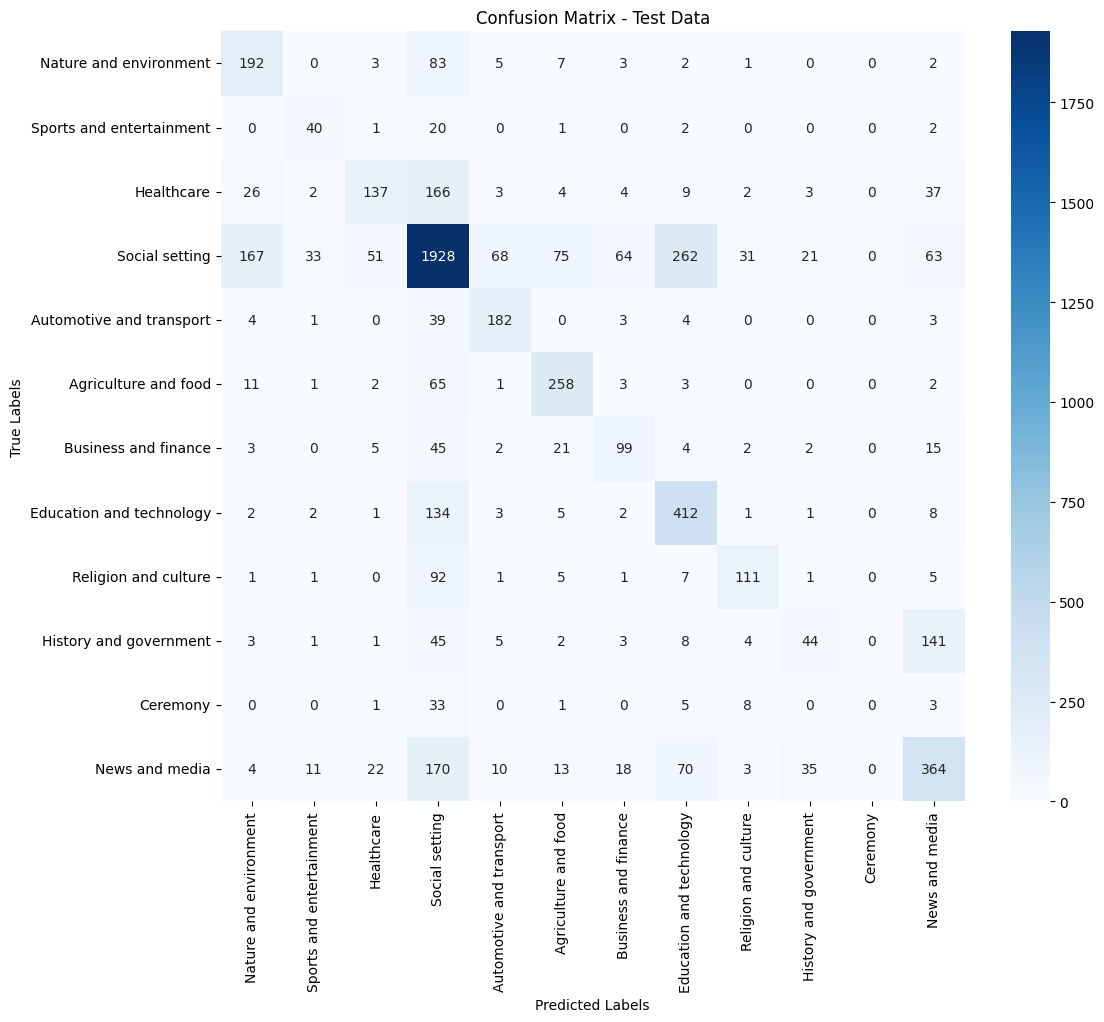

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get predictions from the trainer on the test set
test_outputs = trainer.predict(test_dataset)

# 2. Extract predicted class labels (argmax over logits)
predictions = np.argmax(test_outputs.predictions, axis=1)

# 3. Compute evaluation metrics
accuracy = accuracy_score(test_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predictions, average='weighted')

print(f"Test Accuracy:  {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall:    {recall:.4f}")
print(f"Test F1 Score:  {f1:.4f}")

# 4. Generate confusion matrix
cm = confusion_matrix(test_labels, predictions)

# 5. Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=list(thematic_labels.keys()),  # Make sure thematic_labels is your label->id dict
    yticklabels=list(thematic_labels.keys())
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test Data')
plt.show()

In [ ]:
# Save model and tokenizer

save_directory = "./Fine_tuned_xlm_roberta_model"

# Save model
model.save_pretrained(save_directory)

# Save tokenizer
tokenizer.save_pretrained(save_directory)


('./Fine_tuned_xlm_roberta_model/tokenizer_config.json',
 './Fine_tuned_xlm_roberta_model/special_tokens_map.json',
 './Fine_tuned_xlm_roberta_model/sentencepiece.bpe.model',
 './Fine_tuned_xlm_roberta_model/added_tokens.json')

In [ ]:
!zip -r Fine_tuned_xlm_roberta_model.zip Fine_tuned_xlm_roberta_model/

  adding: Fine_tuned_xlm_roberta_model/ (stored 0%)
  adding: Fine_tuned_xlm_roberta_model/model.safetensors (deflated 27%)
  adding: Fine_tuned_xlm_roberta_model/tokenizer_config.json (deflated 76%)
  adding: Fine_tuned_xlm_roberta_model/config.json (deflated 59%)
  adding: Fine_tuned_xlm_roberta_model/sentencepiece.bpe.model (deflated 49%)
  adding: Fine_tuned_xlm_roberta_model/special_tokens_map.json (deflated 52%)


In [ ]:
from google.colab import files
files.download('Fine_tuned_xlm_roberta_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>